In [15]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [89]:
import os
import copy
import pickle

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

from sklearn.datasets import make_classification

from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.externals import joblib
from sklearn.decomposition import PCA, FastICA

from time import perf_counter

import umap

from utilities import get_reconstruction_error, get_pca_components_for_var, df_to_heatmap, get_max_along_df_axis

In [90]:
# Set n_components to be used during grid searching (was set here based on PCA)
n_components = [2, 3, 4, 5, 13, 23, 27, 30, 32, 35, 40]

In [91]:
# Import shared settings
from settings import random_state, n_jobs, nSamples, max_iter, test_size, class_sep
# Override settings
#...

In [92]:
# Used for plot names
dim_red_name = "ica"
casename = f"synthetic_{dim_red_name}"
# scoreText = "Score (Classification Accuracy)"

# Generate Data

In [93]:
X_full, y_full = make_classification(n_samples=nSamples, n_features=40, n_informative=10, n_redundant=5, n_classes=6, random_state=random_state, class_sep=class_sep)

X, X_test, y, y_test = train_test_split(X_full, y_full, test_size=test_size, 
                                      random_state=random_state, stratify=y_full)

print('')
print(f'X.shape = {X.shape}')
print(f'y.shape = {y.shape}')
print("Fraction of training data for each label = ")
for label in np.unique(y):
    print(f'\tData labelled {label} = {(y == label).sum() / float(len(y))}')

print('')
print(f'X_test.shape = {X_test.shape}')
print(f'y_test.shape = {y_test.shape}')
print("Fraction of testing data for each label = ")
for label in np.unique(y):
    print(f'\tData labelled {label} = {(y == label).sum() / float(len(y))}')


X.shape = (2000, 40)
y.shape = (2000,)
Fraction of training data for each label = 
	Data labelled 0 = 0.165
	Data labelled 1 = 0.169
	Data labelled 2 = 0.17
	Data labelled 3 = 0.1635
	Data labelled 4 = 0.166
	Data labelled 5 = 0.1665

X_test.shape = (500, 40)
y_test.shape = (500,)
Fraction of testing data for each label = 
	Data labelled 0 = 0.165
	Data labelled 1 = 0.169
	Data labelled 2 = 0.17
	Data labelled 3 = 0.1635
	Data labelled 4 = 0.166
	Data labelled 5 = 0.1665


# Reconstruction Error

In [87]:
# n_components = [2, 3, 4, 5, 7, 10, 13, 15, 20, 25, 30, 35, 40]
reconstruction_error = np.zeros(len(n_components))
for i, this_n in enumerate(n_components):
    pipe_reconstruction = Pipeline([('scaler', StandardScaler()), 
                                       (f'{dim_red_name}', FastICA(random_state=random_state, n_components=this_n, max_iter=10000))])
    pipe_reconstruction.fit(X)
    reconstruction_error[i] = get_reconstruction_error(X, pipe_reconstruction)
joblib.dump(np.array((n_components, reconstruction_error)).T, f'{casename}_reconstruction_error.pkl')

C:\Users\Scribs\Anaconda3\lib\site-packages\sklearn\decomposition\fastica_.py:121: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
C:\Users\Scribs\Anaconda3\lib\site-packages\sklearn\decomposition\fastica_.py:121: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
C:\Users\Scribs\Anaconda3\lib\site-packages\sklearn\decomposition\fastica_.py:121: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
C:\Users\Scribs\Anaconda3\lib\site-packages\sklearn\decomposition\fastica_.py:121: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
C:\Users\Scribs\Anaconda3\lib\site-packages\sklearn\decomposition\fastica_.py:121: ConvergenceWarning: FastICA did not converge.

['synthetic_ica_reconstruction_error.pkl']

# Run MLP using results of ICA through Grid Search

In [94]:
pipe = Pipeline([('scaler', StandardScaler()),
                  (f'{dim_red_name}', FastICA(random_state=random_state, max_iter=max_iter)),
                  ('mlp', MLPClassifier(max_iter=max_iter, random_state=random_state))])

#                  [0.5, 0.75, 0.9, 0.95, 0.99]
hidden_layer_sizes = [(2, ), (6, ), (10, ), (15, )]
param_grid = {f'{dim_red_name}__n_components': n_components,
             'mlp__hidden_layer_sizes': hidden_layer_sizes,
             }
gs = GridSearchCV(pipe, param_grid=param_grid, verbose=10, cv=3, return_train_score=True, 
                  n_jobs=n_jobs)

In [95]:
gs.fit(X, y)

Fitting 3 folds for each of 44 candidates, totalling 132 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   10.0s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   14.6s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   19.3s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   30.2s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   37.8s
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:   49.8s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done 132 out of 132 | elapsed:  4.2min finished
C:\Users\Scribs\Anaconda3\lib\site-packages\sklearn\decomposition\fastica_.py:121: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maxim

GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('ica', FastICA(algorithm='parallel', fun='logcosh', fun_args=None, max_iter=3000,
    n_components=None, random_state=1, tol=0.0001, w_init=None,
    whiten=True)), ('mlp', MLPClassifier(activation='relu', alpha=0.0001, ba...=True, solver='adam', tol=0.0001,
       validation_fraction=0.1, verbose=False, warm_start=False))]),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'ica__n_components': [2, 3, 4, 5, 13, 23, 27, 30, 32, 35, 40], 'mlp__hidden_layer_sizes': [(2,), (6,), (10,), (15,)]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=10)

In [96]:
joblib.dump(gs, casename + "_gs.pkl")

['synthetic_ica_gs.pkl']

In [97]:
gs.best_estimator_

Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('ica', FastICA(algorithm='parallel', fun='logcosh', fun_args=None, max_iter=3000,
    n_components=35, random_state=1, tol=0.0001, w_init=None, whiten=True)), ('mlp', MLPClassifier(activation='relu', alpha=0.0001, batch_si...=True, solver='adam', tol=0.0001,
       validation_fraction=0.1, verbose=False, warm_start=False))])

In [98]:
results = pd.DataFrame(gs.cv_results_)
results.to_csv(casename + "_results.csv")

In [99]:
results.loc[:, ["param_mlp__hidden_layer_sizes", f"param_{dim_red_name}__n_components", "mean_test_score", "mean_train_score"]]

,param_mlp__hidden_layer_sizes,param_ica__n_components,mean_test_score,mean_train_score
0,"(2,)",2,0.1635,0.163500
1,"(6,)",2,0.5110,0.515505
2,"(10,)",2,0.5155,0.519506
3,"(15,)",2,0.5205,0.519504
4,"(2,)",3,0.1690,0.169000
5,"(6,)",3,0.5420,0.549509
6,"(10,)",3,0.5520,0.545748
7,"(15,)",3,0.5435,0.551510
8,"(2,)",4,0.3730,0.369498
9,"(6,)",4,0.5665,0.584757


(<Figure size 432x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x2375a35b358>)

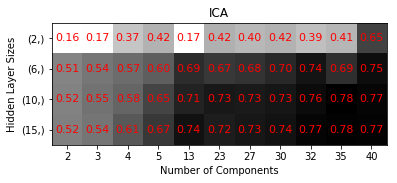

In [100]:
x_variable = f"param_{dim_red_name}__n_components"
y_variable = "param_mlp__hidden_layer_sizes"
z_variable = "mean_test_score"

df_to_heatmap(results, x_variable, y_variable, z_variable, fontsize=11, title=f'{dim_red_name.upper()}', xlabel='Number of Components', ylabel='Hidden Layer Sizes', savefig=f'{casename}_gs.png')

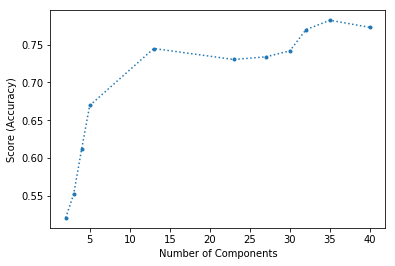

In [101]:
x_variable = f"param_{dim_red_name}__n_components"
z_variable = "mean_test_score"
best_scores = get_max_along_df_axis(results, z_variable, x_variable)
fig, ax = plt.subplots()
ax.plot(best_scores[:, 0], best_scores[:, 1], '.:', label=f'MLP fit on {dim_red_name.upper()}')
ax.set_xlabel("Number of Components")
ax.set_ylabel("Score (Accuracy)")
plt.show()

# Pipeline for kurtosis

In [35]:
kurt_pipe = Pipeline([('scaler', StandardScaler()),
                  (f'{dim_red_name}', FastICA(n_components=40, random_state=random_state, max_iter=max_iter))])

In [36]:
kurt_pipe.fit(X, y)

C:\Users\Scribs\Anaconda3\lib\site-packages\sklearn\decomposition\fastica_.py:121: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)


Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('ica', FastICA(algorithm='parallel', fun='logcosh', fun_args=None, max_iter=3000,
    n_components=40, random_state=1, tol=0.0001, w_init=None, whiten=True))])

In [37]:
X_transformed = kurt_pipe.transform(X)

In [38]:
df_ICA_components = pd.DataFrame(X_transformed)

In [42]:
k_sorted = df_ICA_components.kurt(axis=0).abs().sort_values(ascending=False)

In [60]:
k_sorted.index

Int64Index([13, 36, 39, 10,  3, 34, 37, 21,  4, 23,  8, 18, 14, 17, 29, 11, 38,
            12,  5,  1,  0,  9, 22,  7, 31, 32,  2, 25, 16, 19, 30, 27, 28,  6,
            15, 20, 24, 35, 33, 26],
           dtype='int64')

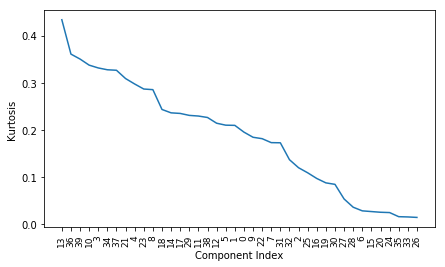

In [79]:
fig, ax = plt.subplots(figsize=(7, 4))

ax.plot(range(len(k_sorted)), k_sorted, )
ax.set_xticklabels(k_sorted.index, rotation='vertical', fontsize=9)
ax.set_xticks(range(len(k_sorted)))
# plt.xticks(k_sorted.index)
# ax.xticks(k_sorted.index)
# ax.xaxis.set_major_locator(MaxNLocator(len(k_sorted.index), integer=True))
ax.set_xlabel("Component Index")
ax.set_ylabel("Kurtosis")
fig.savefig(f'{casename}_kurtosis.png')